# Main Guide

**Author**: Clarence Mah | **Last Updated**: {sub-ref}`today`

Here we will analyze a subset of the U2-OS cell dataset from the Bento paper, in which 130 genes and 5 non-targeting controls are spatially profiled with MERFISH. The full dataset includes 1153 cells, each with cell/nuclear segmentation masks and 2D transcript coordinates. Here we demonstrate Bento's key functionality on a representative subset.


## Setup

Load libraries and configure paths.


In [1]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load Data

Bento includes access to datasets with the package. Datasets are downloaded and stored in `data_home`, which by default is set to `~/bento-data`.

The loaded object is an `AnnData` object, structured similarly to single-cell omics analysis, where observations are cells, features are genes, and the main matrix is an expression count matrix. Bento additionally stores molecular coordinates in `uns['points']` and polygons as columns in `obs`.

```{note}
See the docs on Bento [data structures](../howitworks.md) for more details.
```


In [2]:
adata = bt.ds.sample_data()


You can use built-in plotting functions to visualize data. Here we plot RNA distributions and cell/nuclear segmentation masks.

```{seealso}
See the [data visualization tutorial](Data_Visualization) for a more comprehensive guide on plotting.
```


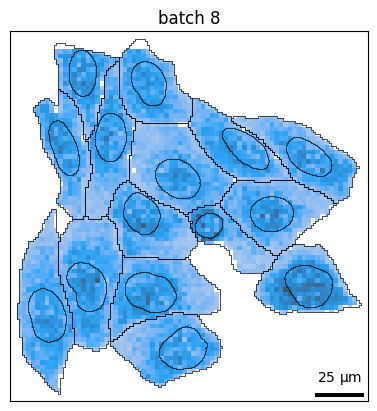

In [3]:
bt.pl.density(adata)


Or visualize a specific gene of interest with `bt.pl.points()`.

```{tip}
Plotting multiple genes can get slow quickly due to plotting the legend; if all you need is a visual, you can set `legend=False` and the plot should render more quickly.
```


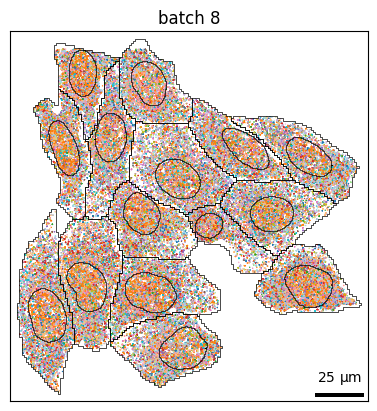

In [4]:
bt.pl.points(adata, hue="gene", legend=False, s=1, palette="tab20")


Let's filter out cells without a nucleus. There are several reasons why this may occur including missing segmentation, overlapping nuclei, or disagreement with cell segmentation. Accurate cell segmentation is a difficult task, especially in samples with high cell density (cells can overlap) and tissue sections.


In [5]:
adata = adata[adata.obs["nucleus_shape"] != None]
bt.sync(adata)
adata


Trying to set attribute `._uns` of view, copying.


AnnData object with n_obs × n_vars = 15 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'point_sets', 'points'
    layers: 'spliced', 'unspliced'

Keep genes where at least 10 molecules are detected in at least one cell.


In [6]:
gene_filter = (adata.X >= 10).sum(axis=0) > 0
adata = adata[:, gene_filter]
bt.sync(adata)
adata


Trying to set attribute `._uns` of view, copying.


AnnData object with n_obs × n_vars = 15 × 133
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'point_sets', 'points'
    layers: 'spliced', 'unspliced'

## Spatial summary statistics

You can get a quick summary of cell and nuclear properties, including area, shape i.e. aspect ratio, and RNA density.

```{seealso}
See the [spatial features tutorial](Spatial_Features) for additional features and how to implement custom ones.
```


In [7]:
bt.tl.obs_stats(adata)


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_area, cell_aspect_ratio, cell_density


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_density, nucleus_aspect_ratio, nucleus_area


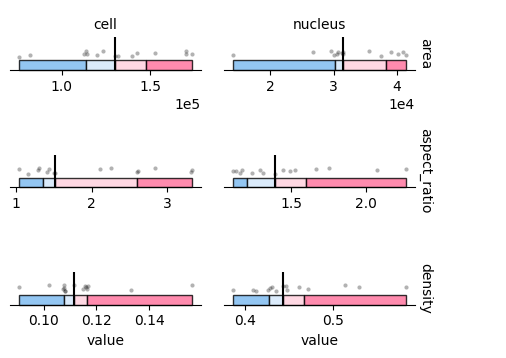

In [8]:
bt.pl.obs_stats(adata)


## Predict subcellular domains


### RNAflux embedding

RNAflux quantifies spatial composition gradients to capture subcellular changes in expression, represented as a `[pixel x gene]` embedding.

```{seealso}
Learn more about [the algorithm here](../howitworks.md).
```


In [9]:
res = 0.1
bt.tl.flux(adata, radius=50, res=res)


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + cell_raster


  0%|          | 0/15 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + cell_raster, flux_embed, flux, flux_variance_ratio, flux_genes, flux_color


`bt.tl.flux()` automatically performs PCA and saves the first 10 principal components (PCs) in `uns['flux_embed']`. We can visualize the first 3 PCs by mapping them to RGB values (red = PC1, green = PC2, and blue = PC3) for each pixel.

```{tip}
The embedding is calculated at 5% unit resolution by default for speed. Higher resolution trades off speed for smoother embeddings. Note that computation time scales quadratically in relation to resolution $r$ or $O(r^{2})$ e.g. 10% resolution takes 4x longer to compute than 5%.
```


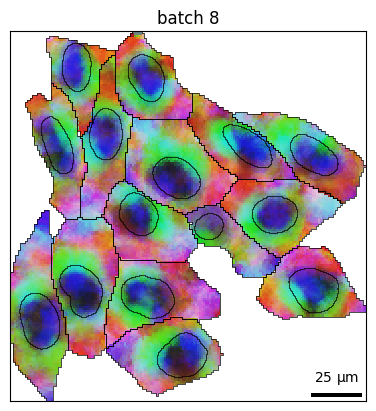

In [10]:
bt.pl.flux(adata, res=res)


### Fluxmaps (RNAflux domains)

To identify distinct subcellular domains in a data-driven manner, we can cluster pixels by their RNAflux embeddings. The `bt.tl.fluxmap()` function fits a self-organizing map (SOM) to the reduced PCA space for a range of cluster numbers. We use the [elbow method heuristic](<https://en.wikipedia.org/wiki/Elbow_method_(clustering)>) to recommend the optimal number of clusters. By default, a line plot will be rendered showing the model fit error for each cluster number and draw a vertical dotted line indicating the recommended number.

```{note}

Determining the number of clusters is not trivial and can be highly subjective. Occasionally, no number is suggested. You can either try a wider range of cluster numbers or manually pick one. We generally recommend settling on a smaller number of clusters i.e. less than 10 for interpretability.
```


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

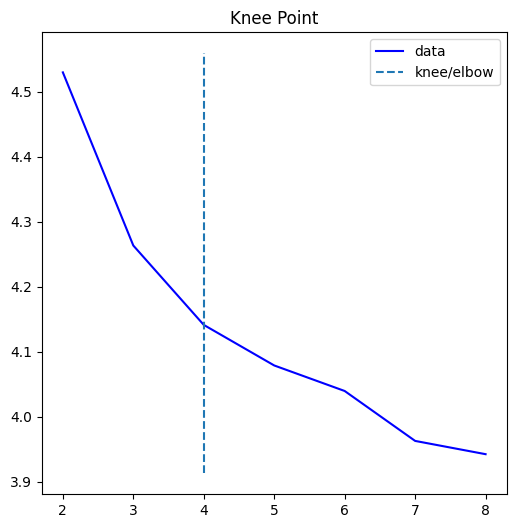

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + fluxmap2_shape, fluxmap3_shape, fluxmap4_shape, fluxmap1_shape


In [11]:
bt.tl.fluxmap(adata, res=res)


Now let's visualize the predicted subcellular domains. Notice how every cell contains instances of each domain (denoted by the different colors).


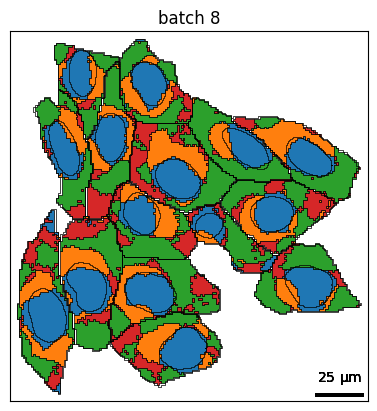

In [12]:
bt.pl.fluxmap(adata)


### Functional enrichment of fluxmaps

We can utilize RNAflux embeddings to compute enrichment scores across the entire area of each cell. Given the appropriate genesets, they can help us identify functionally relevant domains such as organelles and subcellular compartments e.g. the nucleus and cytoplasm. Here we employ published [APEX-seq data](https://doi.org/10.1016/j.cell.2019.05.027) measuring the relative expression (log2 fold change) of genes in various compartments. We can compare geneset enrichment scores to the fluxmaps.


In [13]:
bt.tl.fe_fazal2019(adata)


4 samples of mat are empty, they will be removed.
Running wsum on mat with 19323 samples and 133 targets for 8 sources.
Infering activities on 2 batches.


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]

AnnData object modified:
    uns:
        + flux_Lamina, flux_Nucleus, flux_ER Lumen, flux_Cytosol, flux_OMM, flux_ERM, flux_Nuclear Pore, fe_stats, fe_ngenes, flux_Nucleolus


You can visualize functional enrichment scores with `bt.pl.fe()` as well as specific shapes to overlay. In this case, we showcase the striking correspondence of `fluxmap2` with "OMM" expression (outer mitochondrial membrane).


Trying to set attribute `._uns` of view, copying.


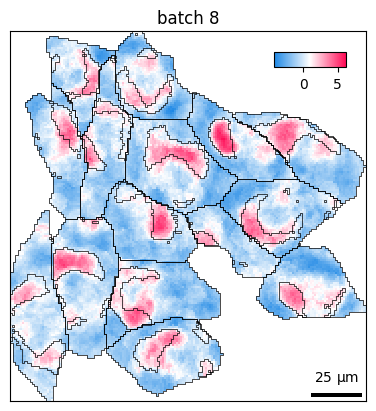

In [14]:
bt.pl.fe(
    adata,
    "flux_OMM",
    res=res,
    shapes=["cell", "fluxmap2"],
)


Here, `fluxmap1` strongly associates with "Nucleus" expression.


Trying to set attribute `._uns` of view, copying.


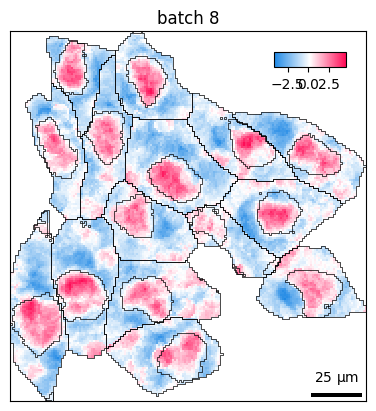

In [15]:
bt.pl.fe(adata, "flux_Nucleus", res=res, shapes=["cell", "fluxmap1"])


## Predict RNA Localization Patterns

We will use the RNAforest model, to predict and annotate subcellular localization patterns. A single "sample" refers to the set of points corresponding to a given gene in a single cell. In the case that every cell expresses every gene, the number of samples is at most $n * m$ for $n$ cells and $m$ genes.

<img src="../_static/tutorial_img/rnaforest_workflow.png" alt="RNA Localization Pattern Annotation Workflow" width="800">

The five subcellular patterns we can predict are:

- **cell edge**: near the cell membrane
- **cytoplasmic**: mostly outside the nucleus in the cytoplasm
- **nuclear**: most in the nucleus
- **nuclear edge**: near the nuclear membrane, either
- **none**: none of the above patterns, more or less randomly distributed

```{seealso}
See [more details about the spatial statistics](../howitworks.md) used as input features for classification.
```


In [16]:
bt.tl.lp(adata)


Calculating cell features...
AnnData object modified:
    obs:
        + cell_radius, cell_maxx, cell_minx, cell_maxy, cell_miny, cell_span
Processing point features...
Saving results...
Done.
AnnData object modified:
    obs:
        + cell_radius, cell_maxx, cell_minx, cell_maxy, cell_miny, cell_span
    uns:
        + cell_gene_features
Calculating cell features...
Processing point features...
Saving results...
Done.
AnnData object modified:
    obs:
        + cell_radius, cell_maxx, cell_minx, cell_maxy, cell_miny, cell_span
    uns:
        + lp, cell_gene_features, lpp


We can view the observed pattern frequencies to get a rough idea of how transcripts are localizing.


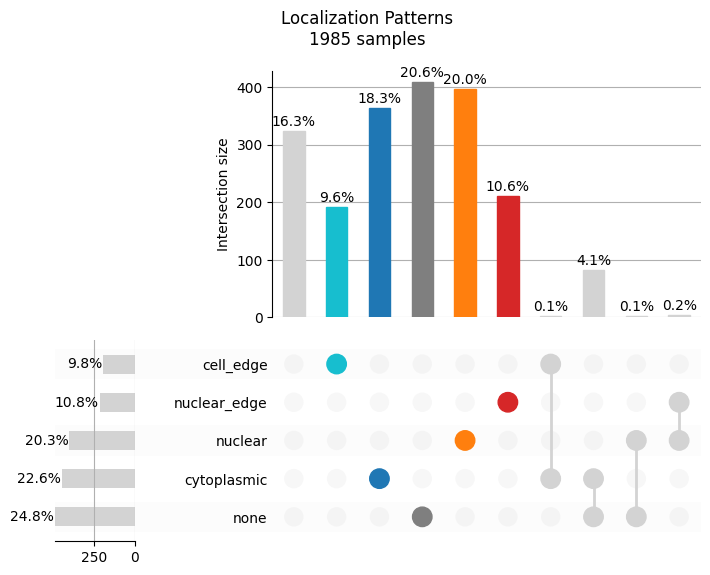

In [17]:
bt.pl.lp_dist(adata, percentage=True)


We can also visualize the localization of each gene where the point position denotes the balance between subcellular localization pattern frequencies. The color denotes the gene's most frequent pattern. Interestingly, we see a wide range of variability in localization. A large number of genes are pulled towards none while nuclear enriched genes show strong bias and a high fraction of cells.


In [18]:
bt.tl.lp_stats(adata)


AnnData object modified:
    uns:
        + lp_stats


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


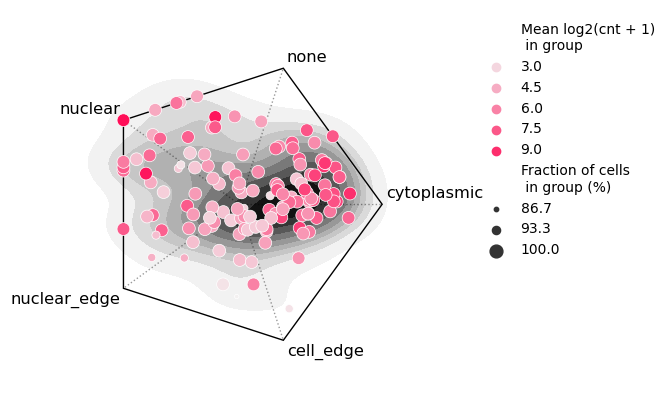

In [19]:
bt.pl.lp_genes(adata, sizes=(10, 85), size_norm=(90, 100))


## Colocalization analysis

Here we use the Colocation Quotient or CLQ ([Leslie & Kronenfeld, 2011](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1538-4632.2011.00821.x)) to measure pairwise colocalization between genes. Given two sets of points, A and B, the CLQ is the ratio of observed to expected proprtion of B among A's neighbors.

At the same time, we quantify colocalization in a compartment-specific manner i.e. transcripts in the nucleus organize differently than they do in the cytoplasm.

<img src="../_static/tutorial_img/clq_workflow.png" alt="colocalization analysis workflow" width="800px" class="p2">


First lets create shapes for the cytoplasm.


In [20]:
# Cytoplasm = cell - nucleus
adata.obs["cytoplasm_shape"] = bt.geo.get_shape(adata, "cell_shape") - bt.geo.get_shape(
    adata, "nucleus_shape"
)

# Create point index
adata.uns["points"]["cytoplasm"] = (
    adata.uns["points"]["nucleus"].astype(int) < 0
).astype(int)


Now we can calculate CLQ values for every gene pair -- one for the cytoplasm and once more for the nucleus.


In [21]:
bt.tl.coloc_quotient(adata, shapes=["cytoplasm_shape", "nucleus_shape"])


cytoplasm_shape:   0%|          | 0/15 [00:00<?, ?it/s]

nucleus_shape:   0%|          | 0/15 [00:00<?, ?it/s]

AnnData object modified:
    uns:
        + clq


We can represent the data as a 3-dimensional tensor: compartments, cells, and gene pairs and apply tensor decomposition - in this case, non-negative PARAFAC ([Shashua & Hazan 2005](https://dl.acm.org/doi/10.1145/1102351.1102451)) - to discover substructure considering cell and compartment-specific patterns.

The data tensor is broken down into $k$ factors. When added together, the factors reconstruct the original data tensor with some degree of error. By plotting the error for each $k$ rank decomposition, we can use the [elbow method heuristic](<https://en.wikipedia.org/wiki/Elbow_method_(clustering)>) to recommend the optimal number of factors.


Preparing tensor...
(2, 15, 17317)
:running: Decomposing tensor...


Device cpu:   0%|          | 0/5 [00:00<?, ?it/s]

:heavy_check_mark: Done.
AnnData object modified:
    uns:
        + factors, tensor_labels, tensor, tensor_names, factors_error


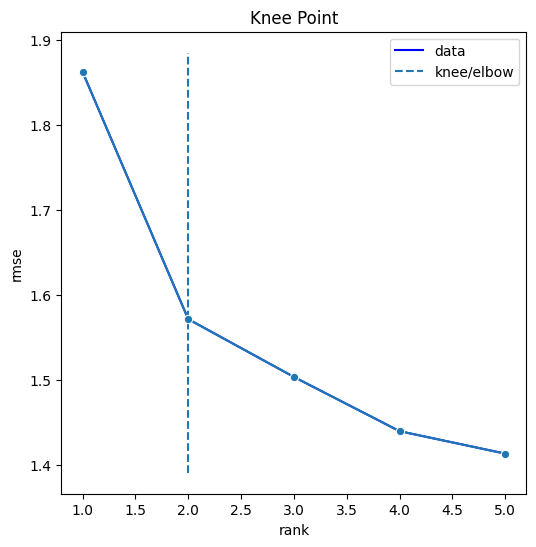

In [22]:
bt.tl.colocation(adata, ranks=range(1, 6))


Let's plot the factor loadings for the suggested $k = 3$. From left to right, the three heatmaps show the loadings of each factor for each dimension – compartments, cells, and gene pairs. We can limit the heatmap to show the top 5 associated gene pairs for each factor.


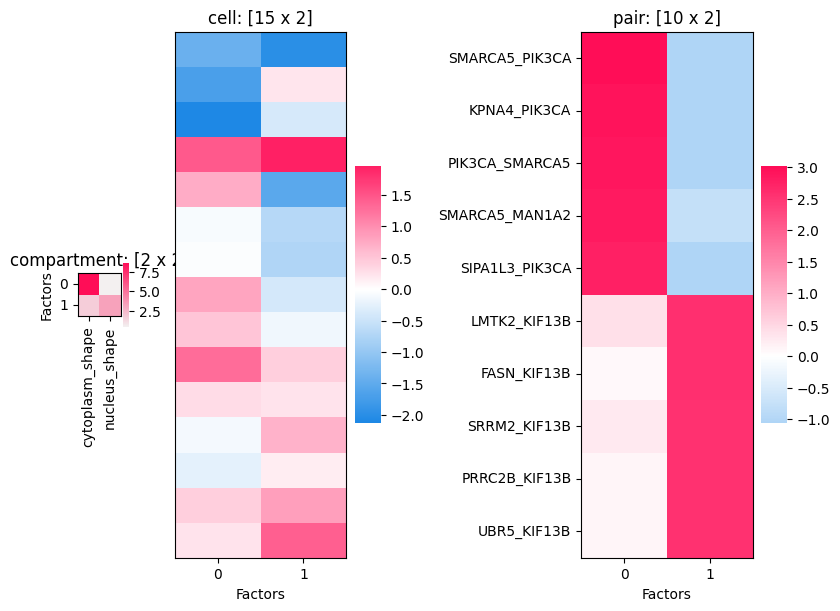

In [23]:
bt.pl.colocation(adata, rank=2)
